<a href="https://colab.research.google.com/github/ethanyoum/Tesla-Predictions/blob/main/EthanYoum_StockProject_RealFinalized.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Tesla Stock Analysis & Prediction Modeling using Deep Learning**

In [1]:
# Import necessary libraries
import time
import yfinance as yf
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
import matplotlib.pyplot as plt

Check with Some Practices

In [ ]:
# Test with NVIDIA
nvda = yf.download('NVDA', start = '2024-11-11', end = '2024-12-14')
nvda['Date'] = nvda.index
nvda.head()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume,Date
Ticker,NVDA,NVDA,NVDA,NVDA,NVDA,
Date,,,,,,
2024-11-11,145.236618,148.826052,143.546903,148.656066,182325600,2024-11-11
2024-11-12,148.266129,149.625910,145.986497,146.756377,198634700,2024-11-12
2024-11-13,146.246475,149.305981,145.876524,149.046028,191903300,2024-11-13
2024-11-14,146.736374,148.976019,145.526577,147.616237,194463300,2024-11-14
2024-11-15,141.957153,145.216639,140.057465,144.846688,250132900,2024-11-15


In [ ]:
aapl_data = yf.download("AAPL", start = '2023-10-01', end = '2024-12-14')
print(aapl_data.columns)

[*********************100%***********************]  1 of 1 completed

MultiIndex([( 'Close', 'AAPL'),
            (  'High', 'AAPL'),
            (   'Low', 'AAPL'),
            (  'Open', 'AAPL'),
            ('Volume', 'AAPL')],
           names=['Price', 'Ticker'])


In [ ]:
# Check Apple's P/E Ratio, P/B Ratio, PEG Ratio respectively as example
aapl = yf.Ticker('AAPL')
pe_ratio = aapl.info['trailingPE']
print(pe_ratio)

pb_ratio = aapl.info['priceToBook']
print(pb_ratio)

peg_ratio = aapl.info.get('pegRatio', None)
print(peg_ratio)

aapl_data = yf.download("AAPL", start = '2023-10-01', end = '2024-12-14', auto_adjust=False)
delta = aapl_data['Adj Close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)

window = 14  # Common period for RSI
avg_gain = gain.rolling(window=window).mean()
avg_loss = loss.rolling(window=window).mean()

# Calculate RS and RSI
rs = avg_gain / avg_loss
rsi = 100 - (100 / (1 + rs))
print(rsi)

[*********************100%***********************]  1 of 1 completed

30.660316
43.52411
None
Ticker           AAPL
Date                 
2023-10-02        NaN
2023-10-03        NaN
2023-10-04        NaN
2023-10-05        NaN
2023-10-06        NaN
...               ...
2024-12-09  96.019715
2024-12-10  96.163014
2024-12-11  90.355378
2024-12-12  92.894975
2024-12-13  92.504660

[304 rows x 1 columns]


In [ ]:
# Add RSI_Classification column to appl_data
aapl_data['RSI_Classification'] = rsi['AAPL'].apply(
    lambda x: "Overestimated" if x > 70 else "Underestimated"
    if x < 30 else "Neutral" if pd.notna(x) else None)

# Display the DataFrame with classifications
print(aapl_data[['RSI_Classification']])

# Check the number of each category
print((aapl_data['RSI_Classification'] == 'Overestimated').sum())
print((aapl_data['RSI_Classification'] == 'Underestimated').sum())
print((aapl_data['RSI_Classification'] == 'Neutral').sum())

Price      RSI_Classification
Ticker                       
Date                         
2023-10-02               None
2023-10-03               None
2023-10-04               None
2023-10-05               None
2023-10-06               None
...                       ...
2024-12-09      Overestimated
2024-12-10      Overestimated
2024-12-11      Overestimated
2024-12-12      Overestimated
2024-12-13      Overestimated

[304 rows x 1 columns]
59
33
199


# **Part 1: Analysis / Visualization**

In [ ]:
# Set up a DataFrame to store results
results = pd.DataFrame(columns=["Financial Indicator", "RSI", "P/E Ratio", "P/B Ratio",
                                "Annualized Volatility", "Classification"])

# RSI calculation
def calculate_rsi(data, window = 14):
    delta = data['Adj Close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window = window).mean()
    avg_loss = loss.rolling(window = window).mean()
    rs = avg_gain/avg_loss.replace(0, np.nan)
    rsi = 100 - (100/(1+rs))
    return float(rsi.dropna().iloc[-1]) if not rsi.dropna().empty else None

# PB ratio calculation - PB ratio I used before only reflects average of total records, so need correction
def calculate_PB(stock_price, book_value):
  if book_value > 0:
    return float(stock_price)/float(book_value)
  return None

TSLA_threshold = {
    'TSLA': {
        'PE_low': 50,
        'PE_high': 150,
        'PB_low': 5,
        'PB_high': 15,
        'Volatility': 0.5
    }
}


# Classification
def classify_stock(ticker, PE, PB, volatility):
    threshold = TSLA_threshold.get(ticker, {})

    if not threshold:
      return 'Unknown'

    if PE is None or PB is None or volatility is None:
      return 'Unknown'

    if PE <threshold['PE_low'] and PB < threshold['PB_low']:
      return 'Underpriced'

    elif threshold['PE_low'] <= PE <= threshold['PE_high'] and threshold['PB_low'] <= PB <= threshold["PB_high"] and volatility <= 0.5:
      return 'Well_priced'

    elif PE > threshold["PE_high"] or PB > threshold["PB_high"] or volatility > 0.5:
      return 'Overpriced'

# 2017/11/14 - 2024/12/14
TSLA = 'TSLA'
data = yf.download(TSLA, start='2017-11-14', end='2024-12-14', auto_adjust=False)

rsi = calculate_rsi(data)
stock = yf.Ticker(TSLA)
info = stock.info
pe_ratio = info.get('trailingPE', None)
book_value = float(info.get('bookValue', None))

if pe_ratio is None or book_value is None:
    print("Missing P/E or Book Value for TSLA.")

stock_price = float(data['Adj Close'].iloc[-1]) if not data.empty else None
pb_ratio = calculate_PB(stock_price, book_value) if book_value else None

data['Daily Return'] = data['Adj Close'].pct_change()
annual_volatility = data['Daily Return'].std() * (252 ** 0.5) if not data.empty else None

# Classify stock
classification = classify_stock(TSLA, pe_ratio, pb_ratio, annual_volatility)

# Add results
new_results = pd.DataFrame([{
            'Financial Indicator': TSLA,
            'RSI': rsi,
            'P/E Ratio': pe_ratio,
            'P/B Ratio': pb_ratio,
            'Annualized Volatility': annual_volatility,
            'Classification': classification
}])
results = pd.concat([results, new_results], ignore_index = True)

results

[*********************100%***********************]  1 of 1 completed
<ipython-input-6-945b260bae2f>:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return float(rsi.dropna().iloc[-1]) if not rsi.dropna().empty else None
<ipython-input-6-945b260bae2f>:65: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  stock_price = float(data['Adj Close'].iloc[-1]) if not data.empty else None
<ipython-input-6-945b260bae2f>:83: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, new_results], ignore_index = True)


,Financial Indicator,RSI,P/E Ratio,P/B Ratio,Annualized Volatility,Classification
0,TSLA,78.326245,117.74146,19.240914,0.63182,Overpriced


[*********************100%***********************]  1 of 1 completed


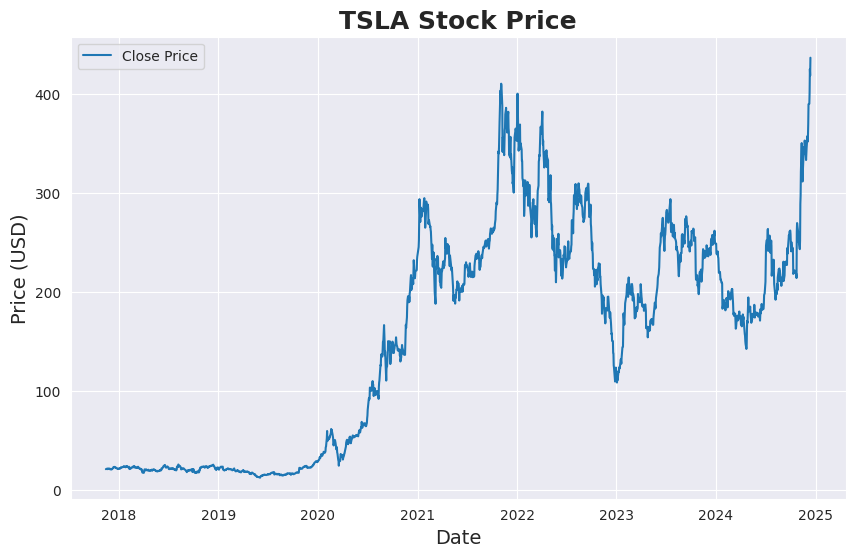

In [ ]:
# Visualization of stock prices from 2017-11-14 to 2024-12-14
data = yf.download(TSLA, start='2017-11-14', end='2024-12-14')
sns.set_style('darkgrid')
plt.figure(figsize=(10, 6))
plt.plot(data['Close'], label='Close Price')
plt.title("TSLA Stock Price", fontsize=18, fontweight='bold')
plt.xlabel("Date", fontsize=14)
plt.ylabel("Price (USD)", fontsize=14)
plt.legend()
plt.show()

[*********************100%***********************]  1 of 1 completed


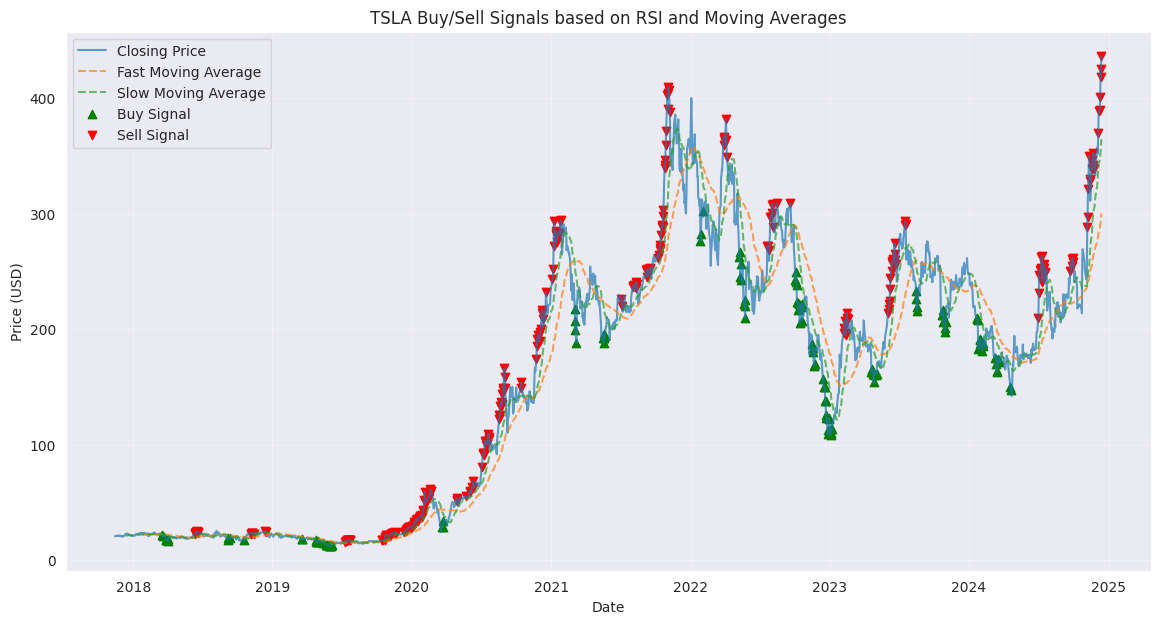

In [ ]:
## Generate Buy/Sell signal with RSI
# Parameters necessary for the signal
data = yf.download(TSLA, start='2017-11-14', end='2024-12-14', auto_adjust=False)
window = 14
slow_moving_period = 20
fast_moving_period = 50
buy_threshold = 30
sell_threshold = 70

# RSI calculation
delta = data['Adj Close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window = window).mean()
avg_loss = loss.rolling(window = window).mean()
rs = avg_gain/avg_loss.replace(0, np.nan)
rsi = 100 - (100/(1 + rs))

data['RSI'] = rsi

# Initialize the signal
data['signal'] = 0

# Moving averages
data['fast_moving_avg'] = data['Adj Close'].rolling(window = fast_moving_period).mean()
data['slow_moving_avg'] = data['Adj Close'].rolling(window = slow_moving_period).mean()

# Buy/Sell Signals
data.loc[(data['fast_moving_avg'] > data['slow_moving_avg']) & (data['RSI'] < buy_threshold), 'signal'] = 1
data.loc[(data['fast_moving_avg'] < data['slow_moving_avg']) & (data['RSI'] > sell_threshold), 'signal'] = -1

# Filter signals for generating plot
buy_signal = data[data['signal'] == 1]
sell_signal = data[data['signal'] == -1]

# Plot
plt.figure(figsize = (14, 7))
plt.plot(data['Adj Close'], label = 'Closing Price', alpha = 0.7)
plt.plot(data['fast_moving_avg'], label = 'Fast Moving Average', alpha = 0.7, linestyle = '--')
plt.plot(data['slow_moving_avg'], label = 'Slow Moving Average', alpha = 0.7, linestyle = '--')
plt.scatter(buy_signal.index, buy_signal['Adj Close'], label = 'Buy Signal', marker='^', color='green', alpha=1)
plt.scatter(sell_signal.index, sell_signal['Adj Close'], label='Sell Signal', marker='v', color='red', alpha=1)
plt.title('TSLA Buy/Sell Signals based on RSI and Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


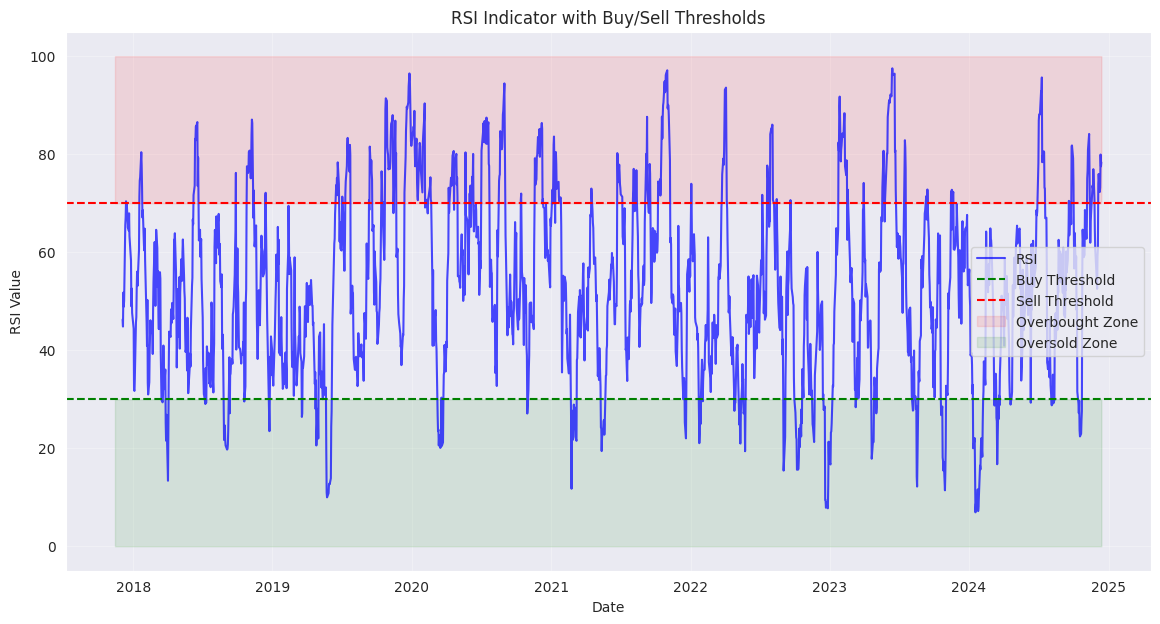

In [ ]:
# Generate the plot of RSI with Buy & Sell Threshold
plt.figure(figsize = (14, 7))
plt.plot(data['RSI'], label = 'RSI', color = 'blue', alpha = 0.7)
plt.axhline(y = buy_threshold, color = 'green', linestyle = '--', label = 'Buy Threshold')
plt.axhline(y = sell_threshold, color = 'red', linestyle = '--', label = 'Sell Threshold')

plt.fill_between(data.index, 70, 100, color = 'red', alpha = 0.1, label = 'Overbought Zone')
plt.fill_between(data.index, 0, 30, color = 'green', alpha = 0.1, label = 'Oversold Zone')

plt.title('RSI Indicator with Buy/Sell Thresholds')
plt.xlabel('Date')
plt.ylabel('RSI Value')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

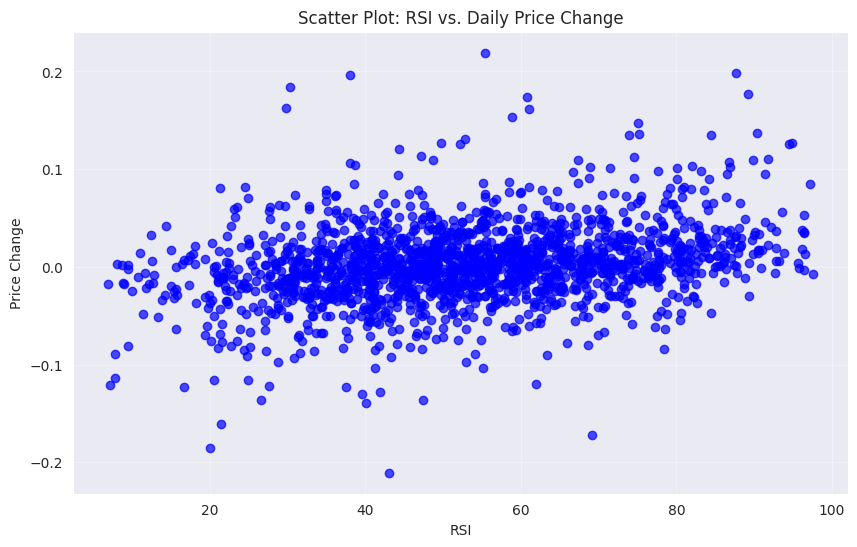

In [ ]:
# Scatter plot of RSI vs Stock Price
data['Daily_Return'] = data['Adj Close'].pct_change()

plt.figure(figsize = (10, 6))
plt.scatter(data['RSI'], data['Daily_Return'], alpha = 0.7, color = 'blue')
plt.title('Scatter Plot: RSI vs. Daily Price Change')
plt.xlabel('RSI')
plt.ylabel('Price Change')
plt.grid(alpha=0.3)
plt.show()


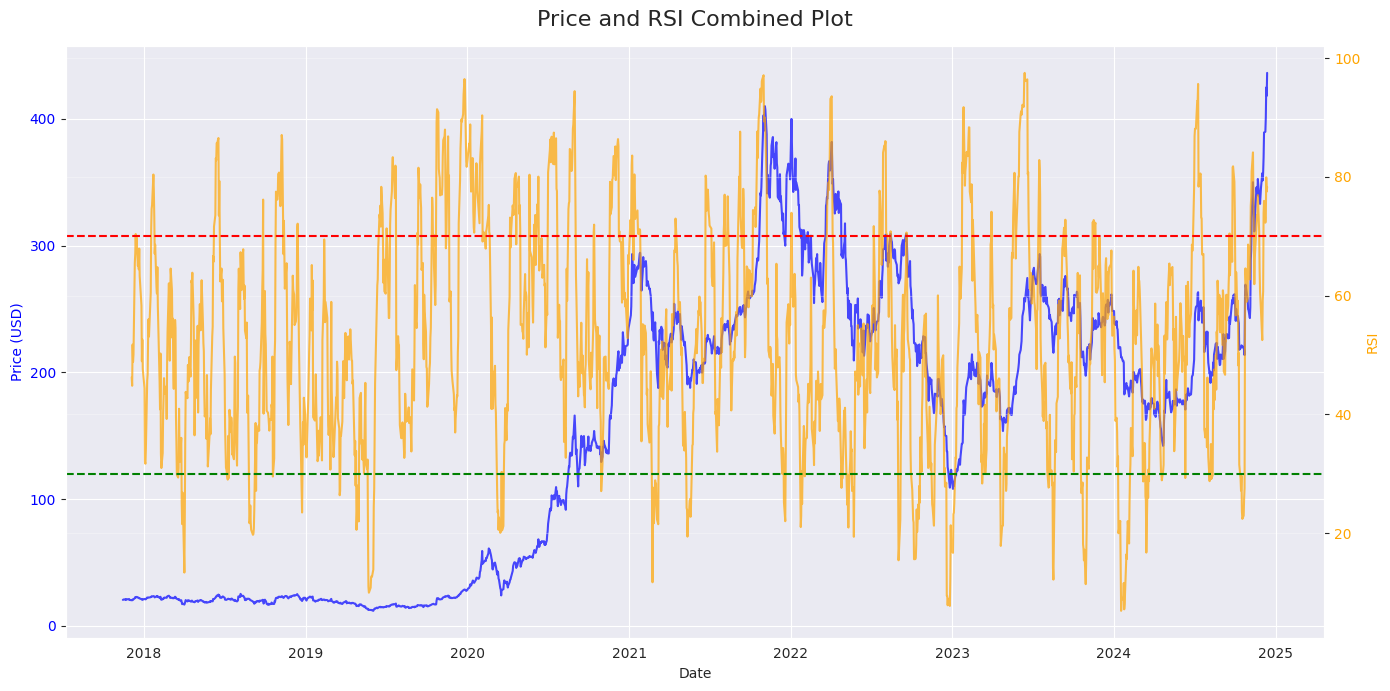

In [ ]:
# Plot with combination of RSI & Price
fig, ax1 = plt.subplots(figsize = (14, 7))
ax1.set_xlabel('Date')
ax1.set_ylabel('Price (USD)', color='blue')
ax1.plot(data['Adj Close'], label='Price', color='blue', alpha=0.7)
ax1.tick_params(axis='y', labelcolor='blue')

# RSI on the right y-axis
ax2 = ax1.twinx()
ax2.set_ylabel('RSI', color='orange')
ax2.plot(data['RSI'], label='RSI', color='orange', alpha=0.7)
ax2.axhline(y=buy_threshold, color='green', linestyle='--', label='Buy Threshold (30)')
ax2.axhline(y=sell_threshold, color='red', linestyle='--', label='Sell Threshold (70)')
ax2.tick_params(axis='y', labelcolor='orange')

fig.suptitle('Price and RSI Combined Plot', fontsize=16)
fig.tight_layout()
plt.grid(alpha=0.3)
plt.show()

# **Part 2: Prediction Modeling**

# Normalize Data

In [ ]:
print(data)

Empty DataFrame
Columns: [Adj Close_TSLA, Close_TSLA, TSLA_5d_return, QQQ, SPY, USO, US10Y, VIX, RSI, MACD, Volume_norm, Earnings, ROC, Stoch_K, Stoch_D, rolling_vol, lag_1]
Index: []


In [2]:
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime

# Download TSLA + external indicators
start_date = '2015-12-14'
end_date = '2025-04-30'
data = yf.download('TSLA', start = start_date, end = end_date)

# Create target: next-day return of TSLA
data['TSLA_5d_return'] = data['Close'].pct_change(periods = 5).shift(-5)

# Macro/external indicators
macro_tickers = ['SPY', 'USO', '^VIX', '^TNX', 'QQQ']
macro_raw = yf.download(macro_tickers, start=start_date, end=end_date)

# Flatten Close prices only and fix column names
macro_data = macro_raw['Close'].copy()
macro_data.columns = [col.replace('^', '') for col in macro_data.columns]
macro_data = macro_data.rename(columns={'TNX': 'US10Y'})

# Both idx to be aligned
macro_data.index = macro_data.index.tz_localize(None)
data.index = data.index.tz_localize(None)

# Flatten data columns
data.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in data.columns]

# Optional: rename for clarity
data = data.rename(columns={
    'Open': 'TSLA_Open',
    'High': 'TSLA_High',
    'Low': 'TSLA_Low',
    'Close': 'TSLA_Close',
    'Adj Close': 'TSLA_AdjClose',
    'Volume': 'TSLA_Volume'
})

# Join all of them
data = data.join(macro_data)

# Drop the last row since it has NaN in the target
data.dropna(inplace=True)

[*********************100%***********************]  1 of 1 completed

YF.download() has changed argument auto_adjust default to True



[*********************100%***********************]  5 of 5 completed


In [3]:
pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=bc8114e56415a67a8fb94b2e21cdd6e15d46e3e8daf2985a72014539ef13f292
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta


In [3]:
from ta.momentum import RSIIndicator
from ta.momentum import StochasticOscillator
from ta.trend import MACD
from ta.volatility import BollingerBands
from ta.momentum import ROCIndicator

lookahead = 5

# Add technical indicators
data['RSI'] = RSIIndicator(data['Close_TSLA'], window = 14).rsi().shift(lookahead)
data['MACD'] = MACD(data['Close_TSLA']).macd().shift(lookahead)
Bollinger_Bands = BollingerBands(data['Close_TSLA'])
data['BB_high'] = Bollinger_Bands.bollinger_hband().shift(lookahead)
data['BB_low'] = Bollinger_Bands.bollinger_lband().shift(lookahead)

In [4]:
# Volume (normalized) & Earnings Date
data['Volume_norm'] = ((data['Volume_TSLA'] - data['Volume_TSLA'].rolling(20).mean()) / data['Volume_TSLA'].rolling(20).std()
).shift(lookahead)

earnings_dates = [
    '2016-02-10', '2016-05-04', '2016-08-03', '2016-10-26',
    '2017-02-22', '2017-05-03', '2017-08-02', '2017-11-01',
    '2018-02-07', '2018-05-02', '2018-08-01', '2018-10-24',
    '2019-01-30', '2019-04-24', '2019-07-24', '2019-10-23',
    '2020-01-29', '2020-04-29', '2020-07-22', '2020-10-21',
    '2021-01-27', '2021-04-26', '2021-07-26', '2021-10-20',
    '2022-01-26', '2022-04-20', '2022-07-20', '2022-10-19',
    '2023-01-25', '2023-04-19', '2023-07-19', '2023-10-18',
    '2024-01-24', '2024-04-23', '2024-07-23', '2024-10-23',
    '2025-01-29']

data['Earnings'] = data.index.isin(pd.to_datetime(earnings_dates)).astype(int)

In [5]:
# Seasonality
data['Day_of_Week'] = data.index.dayofweek
data['Month'] = data.index.month
data['Quarter'] = data.index.quarter

In [6]:
# Momentum indicators
data['ROC'] = ROCIndicator(data['Close_TSLA']).roc()
stoch = StochasticOscillator(data['High_TSLA'], data['Low_TSLA'], data['Close_TSLA'])

# Stoch_K (%K) = Raw Stochastic Oscillator value, Stoch_D (%D) = Moving average of %K
data['Stoch_K'] = stoch.stoch().shift(lookahead)
data['Stoch_D'] = stoch.stoch_signal().shift(lookahead)

In [7]:
# Regime Indicators
data['rolling_vol'] = data['Close_TSLA'].rolling(window = 20).std().shift(lookahead)
data['rolling_mean'] = data['Close_TSLA'].rolling(window = 20).mean().shift(lookahead)

In [8]:
# Lagged Returns
data['lag_1'] = data['Close_TSLA'].pct_change(1).shift(1)
data['lag_2'] = data['Close_TSLA'].pct_change(1).shift(2)
data['lag_3'] = data['Close_TSLA'].pct_change(1).shift(3)

In [9]:
## Feature Pruning
# Drop less useful or problematic columns
drop_cols = ['Open_TSLA', 'Volume_TSLA','High_TSLA', 'Low_TSLA', 'rolling_mean',
    'BB_high', 'BB_low', 'lag_2', 'lag_3', 'Day_of_Week', 'Month', 'Quarter']
data.drop(columns = [col for col in drop_cols if col in data.columns], inplace = True)
data.dropna(inplace = True)

In [10]:
# Finalize dataframe
data = data.rename(columns = {'TSLA_5d_return_': 'TSLA_5d_return'})
features = data.drop(columns = ['TSLA_5d_return'])
#target = data[['TSLA_5d_return']]

# Scale features
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
features_scaled = pd.DataFrame(scaler.fit_transform(features), columns=features.columns, index=features.index)

#target_scaler = RobustScaler()
#target_scaled = target_scaler.fit_transform(target)
#data['TSLA_5d_return_scaled'] = target_scaled

In [11]:
data['direction'] = (data['TSLA_5d_return'] > 0).astype(int)
target = data['direction'].values.astype(np.float32)

In [12]:
features.head(10)

,Close_TSLA,QQQ,SPY,USO,US10Y,VIX,RSI,MACD,Volume_norm,Earnings,ROC,Stoch_K,Stoch_D,rolling_vol,lag_1
Date,,,,,,,,,,,,,,,
2016-01-28,12.646667,95.208992,161.673828,77.599998,1.985,22.420000,31.943029,-0.420907,-0.279700,0,-8.732259,16.704978,17.831706,0.916591,-0.028363
2016-01-29,12.746667,97.197159,165.615005,77.199997,1.931,20.200001,35.906268,-0.421308,-0.351110,0,-8.939372,28.158479,19.695483,0.923898,0.008667
2016-02-01,13.129333,97.458549,165.555161,72.160004,1.966,19.980000,31.223438,-0.449634,-0.685460,0,-1.682399,14.393937,19.752465,0.946739,0.007907
2016-02-02,12.185333,95.349007,162.571487,68.559998,1.864,21.980000,29.340020,-0.481700,0.754208,0,-11.349303,14.828910,19.127109,0.964475,0.030021
2016-02-03,11.565333,94.891640,163.546143,74.720001,1.881,21.650000,26.046070,-0.530530,-0.326861,0,-15.371484,6.633952,11.952266,0.999201,-0.071900
2016-02-04,11.688667,94.882301,163.802551,72.959999,1.864,21.840000,28.608784,-0.554073,0.373357,0,-14.356188,19.169047,13.543970,0.958588,-0.050881
2016-02-05,10.840000,91.587296,160.682098,71.279999,1.848,23.379999,30.979122,-0.558226,-1.002782,0,-18.168093,27.434437,17.745812,0.873099,0.010664
2016-02-08,9.866000,90.187187,158.519150,69.120003,1.735,26.000000,39.286320,-0.524593,0.873674,0,-25.993897,46.377216,30.993567,0.704256,-0.072606
2016-02-09,9.883333,89.907158,158.527664,65.440002,1.729,26.540001,29.767995,-0.567569,1.419969,0,-26.808195,7.865516,27.225723,0.705204,-0.089852


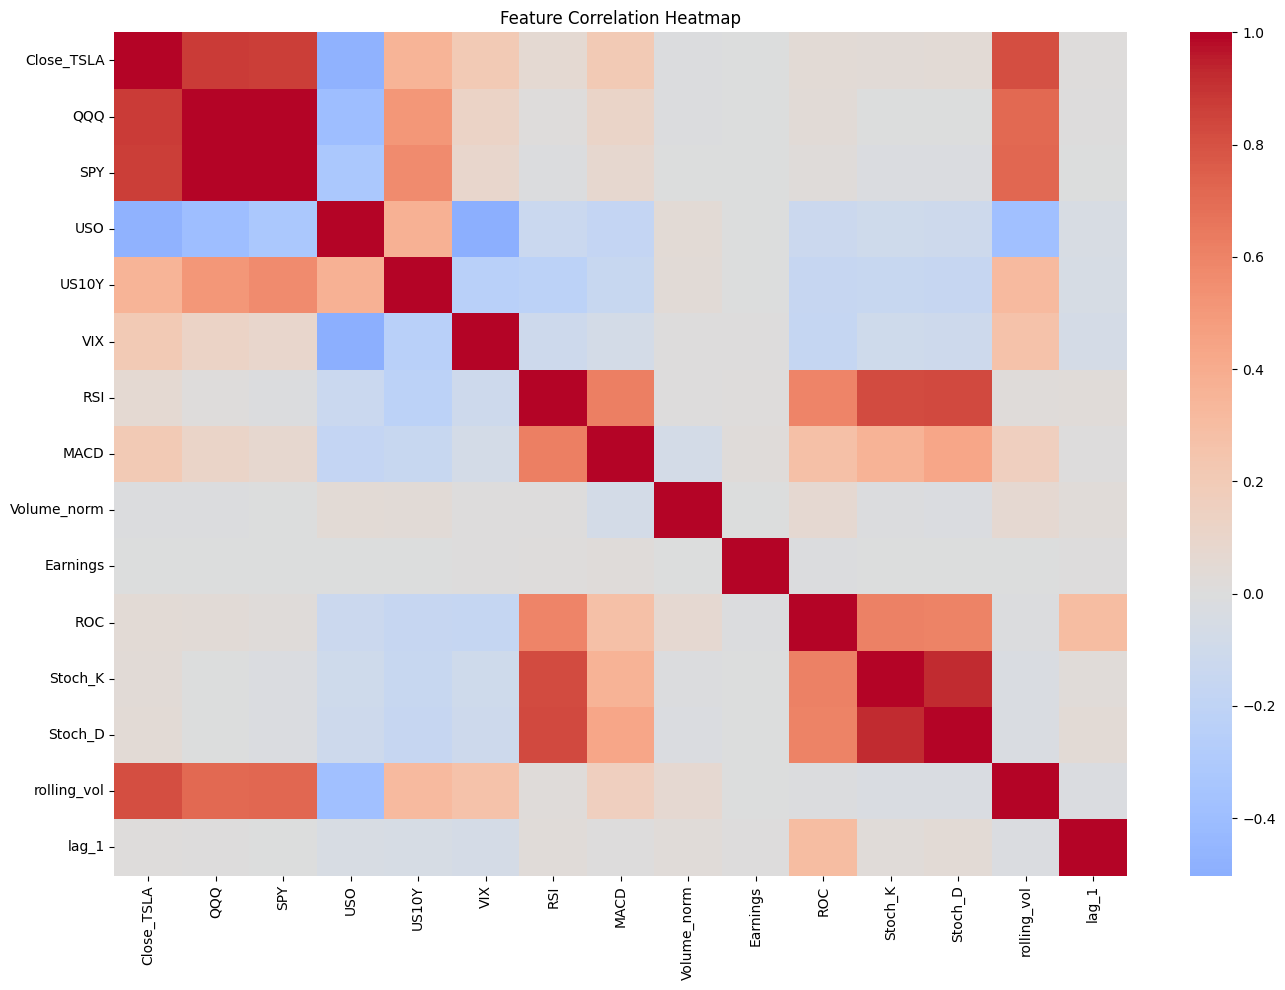

In [13]:
# 1) Feature correlation check
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 10))
sns.heatmap(features_scaled.corr(), cmap='coolwarm', center=0, annot=False)
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.show()

In [ ]:
## 2) PCA - Not appropriate
from sklearn.decomposition import PCA

n_components = 10
data_pca = PCA(n_components=n_components)
features_pca = data.drop(columns=['TSLA_5d_return'])
features_pca_transformed = data_pca.fit_transform(features_pca)

import pandas as pd
features_pca_df = pd.DataFrame(features_pca_transformed, index=data.index,
                               columns=[f'PC{i+1}' for i in range(n_components)])
data_pca_final = pd.concat([features_pca_df, data[['TSLA_5d_return', 'TSLA_5d_return_scaled']]], axis=1)

In [ ]:
data_pca_final

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,TSLA_5d_return,TSLA_5d_return_scaled
Date,,,,,,,,,,,,
2016-01-28,-347.700998,-78.609103,-44.956235,-26.596697,-4.788265,-3.979973,-2.362051,4.880238,-5.534921,-5.234972,-0.075751,-0.895749
2016-01-29,-345.605688,-74.350539,-36.048913,-21.893844,-5.240645,-3.357239,-0.909034,10.541138,-2.769369,-4.805756,-0.149582,-1.690799
2016-02-01,-345.323652,-74.786817,-43.561701,-30.209584,-8.158558,-4.319960,2.037917,-1.034059,-5.078789,-5.925991,-0.248553,-2.756578
2016-02-02,-347.550569,-78.221446,-45.863310,-29.224463,-12.402591,-3.763183,-3.696917,4.430173,-9.804485,-4.895216,-0.188916,-2.114371
2016-02-03,-348.464019,-78.005418,-57.547441,-30.988940,-6.262315,-3.903697,-5.971145,5.467982,-10.665485,-5.216885,-0.171835,-1.930440
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-02,624.605963,103.919998,63.389287,-22.698549,33.386821,51.101925,-16.511976,10.392434,-3.639505,0.648830,0.091574,0.906100
2024-12-03,624.416586,103.981250,44.152673,-23.550448,33.243283,50.029449,-14.035563,-2.462381,-3.925093,-2.037957,0.141056,1.438958
2024-12-04,635.207635,105.890131,37.817999,-25.252948,31.809413,46.491475,-14.243302,-1.612643,-2.486149,-2.121435,0.186740,1.930912


In [14]:
target_series = pd.Series(target, index=features_scaled.index, name='direction')

In [15]:
data_final = pd.concat([features_scaled, target_series], axis = 1)

In [16]:
data_final

,Close_TSLA,QQQ,SPY,USO,US10Y,VIX,RSI,MACD,Volume_norm,Earnings,ROC,Stoch_K,Stoch_D,rolling_vol,lag_1,direction
Date,,,,,,,,,,,,,,,,
2016-01-28,-0.513476,-0.855504,-0.849922,0.032179,-0.232718,0.706876,-1.050890,-0.160690,-0.045626,0.0,-0.631304,-0.704526,-0.725806,-0.365953,-0.797269,0.0
2016-01-29,-0.513012,-0.845354,-0.827936,0.015886,-0.261214,0.439083,-0.836186,-0.160803,-0.101162,0.0,-0.644334,-0.505636,-0.691560,-0.365393,0.199113,0.0
2016-02-01,-0.511235,-0.844019,-0.828270,-0.189409,-0.242744,0.412545,-1.089873,-0.168772,-0.361190,0.0,-0.187769,-0.744657,-0.690513,-0.363642,0.178672,0.0
2016-02-02,-0.515619,-0.854789,-0.844914,-0.336049,-0.296570,0.653800,-1.191905,-0.177793,0.758455,0.0,-0.795952,-0.737104,-0.702003,-0.362282,0.773687,0.0
2016-02-03,-0.518498,-0.857124,-0.839477,-0.085132,-0.287599,0.613993,-1.370351,-0.191531,-0.082303,0.0,-1.049004,-0.879410,-0.833838,-0.359620,-1.968722,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-15,0.607822,0.996526,1.247200,-0.420774,1.001055,1.635706,-0.845634,-3.868844,0.905660,0.0,-0.307271,-0.824315,-0.692125,1.079969,-0.029824,0.0
2025-04-16,0.549496,0.926025,1.180538,-0.369043,0.977836,1.939687,-0.005520,-3.138356,1.780477,0.0,-0.509425,0.302174,-0.385721,1.109306,0.153572,1.0
2025-04-17,0.548660,0.925617,1.184721,-0.298574,1.006332,1.579011,-0.262927,-2.975123,0.876431,0.0,-0.716780,-0.140903,-0.234889,1.089287,-1.364046,1.0


In [17]:
## Save the dataframe
data_final.to_parquet('DATA.parquet')
data_final.to_csv('DATA.csv')

In [71]:
data = pd.read_parquet('DATA.parquet')

In [6]:
data_final = pd.read_csv('DATA.csv')

In [17]:
def data_split_multivariate_return(df, lookback):
    """
    Splits multivariate time series data into training and testing sets for 5-day return prediction.

    Args:
        df (pd.DataFrame): Feature-enhanced DataFrame with target in the last column.
        lookback (int): Number of past time steps to use for prediction.

    Returns:
        x_train, y_train, x_test, y_test: Torch-ready numpy arrays.
    """
    raw_data = df.to_numpy()
    x, y = [], []

    for i in range(len(raw_data) - lookback):
        x.append(raw_data[i:i+lookback, :-1])      # all features except target
        y.append(raw_data[i+lookback-1, -1])       # 5-day return (last column)

    x = np.array(x)
    y = np.array(y).reshape(-1, 1)

    test_size = int(0.2 * len(x))
    x_train, y_train = x[:-test_size], y[:-test_size]
    x_test, y_test = x[-test_size:], y[-test_size:]

    return x_train, y_train.reshape(-1, 1), x_test, y_test.reshape(-1, 1)

In [18]:
data_final = data_final.dropna()

In [19]:
x_train, y_train, x_test, y_test = data_split_multivariate_return(data_final, lookback=20)

In [20]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(1841, 20, 15)
(460, 20, 15)
(1841, 1)
(460, 1)


# *RNN* *Model Construction*

In [ ]:
class RNN(nn.Module):
  def __init__(self, input_dim, output_dim, hidden_dim, num_layers):
    super(RNN, self).__init__()
    self.rnn = nn.RNN(input_dim, hidden_dim, num_layers, batch_first = True)
    self.fc = nn.Linear(hidden_dim, output_dim)

  def forward(self, x, hidden):
    r_output, hidden = self.rnn(x, hidden)
    output = self.fc(r_output[:, -1, :])
    return output, hidden

In [ ]:
# Test and check dimensions
test_rnn = RNN(input_dim=1, output_dim=1, hidden_dim=10, num_layers=2)

# Generate evenly spaced, test data pts
test_input= x_train[0:64,:,:]

# test_input = test_data.unsqueeze(0) # give it a batch_size of 1 as first dimension
print('Input size: ', test_input.size())

# test out rnn sizes
test_out, test_h = test_rnn(test_input, None)
print('Output size: ', test_out.size())
print('Hidden state size: ', test_h.size())

Input size:  torch.Size([64, 20, 4])


RuntimeError: input.size(-1) must be equal to input_size. Expected 1, got 4

# Train RNN

In [ ]:
# Define parameters
input_dim = 1
output_dim = 1
hidden_dim = 32
num_layers = 2

rnn = RNN(input_dim, output_dim, hidden_dim, num_layers)
print(rnn)

RNN(
  (rnn): RNN(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)


In [ ]:
# Specify Loss function
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.01)

In [ ]:
# Training
def train_model(model, x_train, y_train, num_epochs):
  start_time = time.time()
  train_losses = np.zeros(num_epochs)

  for epoch in range(num_epochs):
    total_train_losses = 0.0
    hidden = None
    y_train_pred, hidden = model(x_train, hidden)
    loss = criterion(y_train_pred, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print('Epoch', epoch + 1, 'MSE:', loss.item())
    train_losses[epoch] = loss.item()
  training_time = time.time() - start_time
  print('training time: {}'.format(training_time))

  return y_train_pred, train_losses, training_time

In [ ]:
rnn_train_pred, rnn_train_losses, rnn_training_time = train_model(rnn, x_train, y_train, num_epochs = 100)

Epoch 1 MSE: 0.4002085328102112
Epoch 2 MSE: 0.3048360347747803
Epoch 3 MSE: 0.20125164091587067
Epoch 4 MSE: 0.18533290922641754
Epoch 5 MSE: 0.1497064232826233
Epoch 6 MSE: 0.06795838475227356
Epoch 7 MSE: 0.041492562741041183
Epoch 8 MSE: 0.04977698624134064
Epoch 9 MSE: 0.02540474943816662
Epoch 10 MSE: 0.03870989382266998
Epoch 11 MSE: 0.02000630646944046
Epoch 12 MSE: 0.008873187936842442
Epoch 13 MSE: 0.016588672995567322
Epoch 14 MSE: 0.025728467851877213
Epoch 15 MSE: 0.020737089216709137
Epoch 16 MSE: 0.00885837897658348
Epoch 17 MSE: 0.0036715471651405096
Epoch 18 MSE: 0.0067418660037219524
Epoch 19 MSE: 0.010810526087880135
Epoch 20 MSE: 0.011125386692583561
Epoch 21 MSE: 0.009336105547845364
Epoch 22 MSE: 0.007882925681769848
Epoch 23 MSE: 0.006017133127897978
Epoch 24 MSE: 0.0036695697344839573
Epoch 25 MSE: 0.0028031030669808388
Epoch 26 MSE: 0.0040806969627738
Epoch 27 MSE: 0.005897547118365765
Epoch 28 MSE: 0.0064175063744187355
Epoch 29 MSE: 0.005309498403221369
Epoch

In [ ]:
# Inverse transform the values to plot the graph comparing actual vs predicted
predict = pd.DataFrame(scaler.inverse_transform(rnn_train_pred.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train.detach().numpy()))

# Plotting the comparison actual vs predicted
def plot_training_results(predict, original, train_losses, model_name):
    sns.set_style("darkgrid")
    fig = plt.figure()
    fig.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.subplot(1, 2, 1)
    ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
    ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (" + model_name +")" , color='tomato')
    ax.set_title(ticker+' Stock price', size = 14, fontweight='bold')
    ax.set_xlabel("Days", size = 14)
    ax.set_ylabel("Price (USD)", size = 14)
    ax.set_xticklabels('', size=10)

    plt.subplot(1, 2, 2)
    ax = sns.lineplot(data=train_losses, color='royalblue')
    ax.set_xlabel("Epoch", size = 14)
    ax.set_ylabel("Loss", size = 14)
    ax.set_title("Training Loss", size = 14, fontweight='bold')
    fig.set_figheight(6)
    fig.set_figwidth(16)

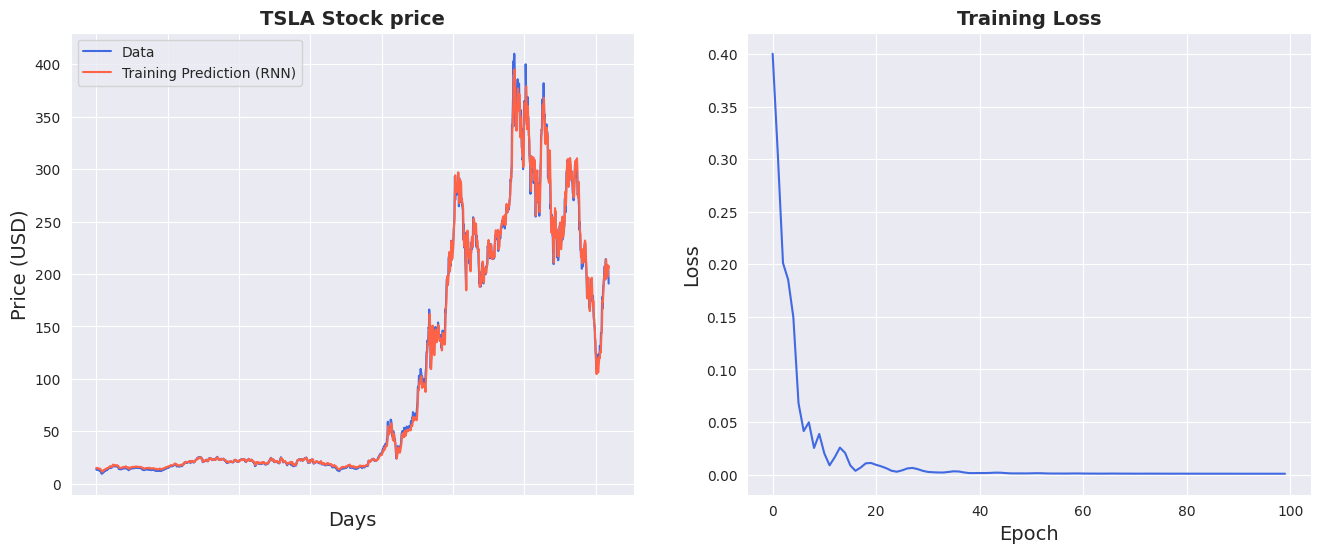

In [ ]:
plot_training_results(predict, original, rnn_train_losses, 'RNN')

In [ ]:
import math, time
from sklearn.metrics import mean_squared_error

def evaluate_model(model,x_test,y_test,y_train,y_train_pred):
  result=[]

  hidden = None
  y_test_pred, hidden = model(x_test, hidden)

  # Invert predictions
  y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
  y_test_orig = scaler.inverse_transform(y_test.detach().numpy())
  y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
  y_train_orig = scaler.inverse_transform(y_train.detach().numpy())

  # Calculate root mean squared error
  trainScore = math.sqrt(mean_squared_error(y_train_orig[:,0], y_train_pred[:,0]))
  print('Train Score: %.2f RMSE' % (trainScore))
  testScore = math.sqrt(mean_squared_error(y_test_orig[:,0], y_test_pred[:,0]))
  print('Test Score: %.2f RMSE' % (testScore))
  result.append(trainScore)
  result.append(testScore)
  result.append(rnn_training_time)
  return y_test_pred, result

In [ ]:
rnn_test_pred, rnn_result=evaluate_model(rnn,x_test,y_test,y_train,rnn_train_pred)

Train Score: 6.41 RMSE
Test Score: 9.08 RMSE


In [ ]:
import plotly.express as px
import plotly.graph_objects as go

def predictions_plot(y_train_pred,y_test_pred, model_name):
  y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())

  # Shift train predictions for plotting
  trainPredictPlot = np.empty_like(price)
  trainPredictPlot[:, :] = np.nan
  trainPredictPlot[window:len(y_train_pred) + window, :] = y_train_pred

  # Shift test predictions for plotting
  testPredictPlot = np.empty_like(price)
  testPredictPlot[:, :] = np.nan
  testPredictPlot[len(y_train_pred) + window - 1:len(price) - 1, :] = y_test_pred

  original = scaler.inverse_transform(price['Close'].values.reshape(-1, 1))
  predictions = np.append(trainPredictPlot, testPredictPlot, axis = 1)
  predictions = np.append(predictions, original, axis = 1)
  result = pd.DataFrame(predictions)

  fig = go.Figure()
  fig.add_trace(go.Scatter(go.Scatter(x=data['Date'], y=result[0],
                    mode='lines',
                    name='Train prediction')))
  fig.add_trace(go.Scatter(x=data['Date'], y=result[1],
                    mode='lines',
                    name='Test prediction'))
  fig.add_trace(go.Scatter(go.Scatter(x=data['Date'], y=result[2],
                    mode='lines',
                    name='Actual Value')))
  fig.update_layout(
    xaxis=dict(
        showline=True,
        showgrid=True,
        showticklabels=True,
        linecolor='white',
        linewidth=2
    ),
    yaxis=dict(
        title_text='Close (USD)',
        titlefont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
        showline=True,
        showgrid=True,
        showticklabels=True,
        linecolor='white',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
    ),
    showlegend=True,
    template = 'plotly_dark'

  )

  annotations = []
  annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Tesla Stock Price Change ('+ model_name + ')',
                              font=dict(family='Rockwell',
                                        size=26,
                                        color='white'),
                              showarrow=False))
  fig.update_layout(annotations=annotations)

  fig.show()

In [ ]:
predictions_plot(rnn_train_pred,rnn_test_pred,'RNN')

# *LSTM Model Construction*

In [ ]:
class LSTM(nn.Module):
  def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
    super(LSTM, self).__init__()
    self.hidden_dim = hidden_dim
    self.num_layers = num_layers
    self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first = True)
    self.fc = nn.Linear(hidden_dim, output_dim)

  def forward(self, x):

    # Initialize hidden states
    h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_() # Shot-term memory
    c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_() # Long-term memory

    # Get the outputs and the new hidden state
    out, (h0, c0) = self.lstm(x, (h0.detach(), c0.detach()))

    # Put out through the fully-connected layer
    out = self.fc(out[:, -1, :])
    return out


In [ ]:
lstm = LSTM(input_dim = input_dim, hidden_dim = hidden_dim, num_layers = num_layers, output_dim = output_dim)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr = 0.01)

In [ ]:
print(lstm)

LSTM(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)


# Train LSTM

In [ ]:
def train_model_lstm(model, x_train, y_train, num_epochs):
  train_losses = np.zeros(num_epochs)
  start_time = time.time()

  for epoch in range(num_epochs):
    y_train_pred = model(x_train)
    loss = criterion(y_train_pred, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print("Epoch ", epoch, "MSE: ", loss.item())
    train_losses[epoch] = loss.item()

  training_time = time.time() - start_time
  print("Training time: {}".format(training_time))

  return y_train_pred, train_losses, training_time


In [ ]:
lstm_train_pred, lstm_train_losses, lstm_training_time = train_model_lstm(lstm, x_train, y_train, num_epochs = 100)

Epoch  0 MSE:  0.4807833135128021
Epoch  1 MSE:  0.38367798924446106
Epoch  2 MSE:  0.29344454407691956
Epoch  3 MSE:  0.21429592370986938
Epoch  4 MSE:  0.322010338306427
Epoch  5 MSE:  0.2103748917579651
Epoch  6 MSE:  0.16980692744255066
Epoch  7 MSE:  0.1717437356710434
Epoch  8 MSE:  0.1671331822872162
Epoch  9 MSE:  0.14037686586380005
Epoch  10 MSE:  0.09199327230453491
Epoch  11 MSE:  0.05204009637236595
Epoch  12 MSE:  0.050050534307956696
Epoch  13 MSE:  0.04760372266173363
Epoch  14 MSE:  0.031413156539201736
Epoch  15 MSE:  0.02536896802484989
Epoch  16 MSE:  0.03337879851460457
Epoch  17 MSE:  0.03580092638731003
Epoch  18 MSE:  0.03187397122383118
Epoch  19 MSE:  0.027993693947792053
Epoch  20 MSE:  0.026199139654636383
Epoch  21 MSE:  0.025050407275557518
Epoch  22 MSE:  0.02351374365389347
Epoch  23 MSE:  0.021923735737800598
Epoch  24 MSE:  0.021123787388205528
Epoch  25 MSE:  0.021425480023026466
Epoch  26 MSE:  0.02211473323404789
Epoch  27 MSE:  0.02189181186258793


In [ ]:
predict_lstm = pd.DataFrame(scaler.inverse_transform(lstm_train_pred.detach().numpy()))

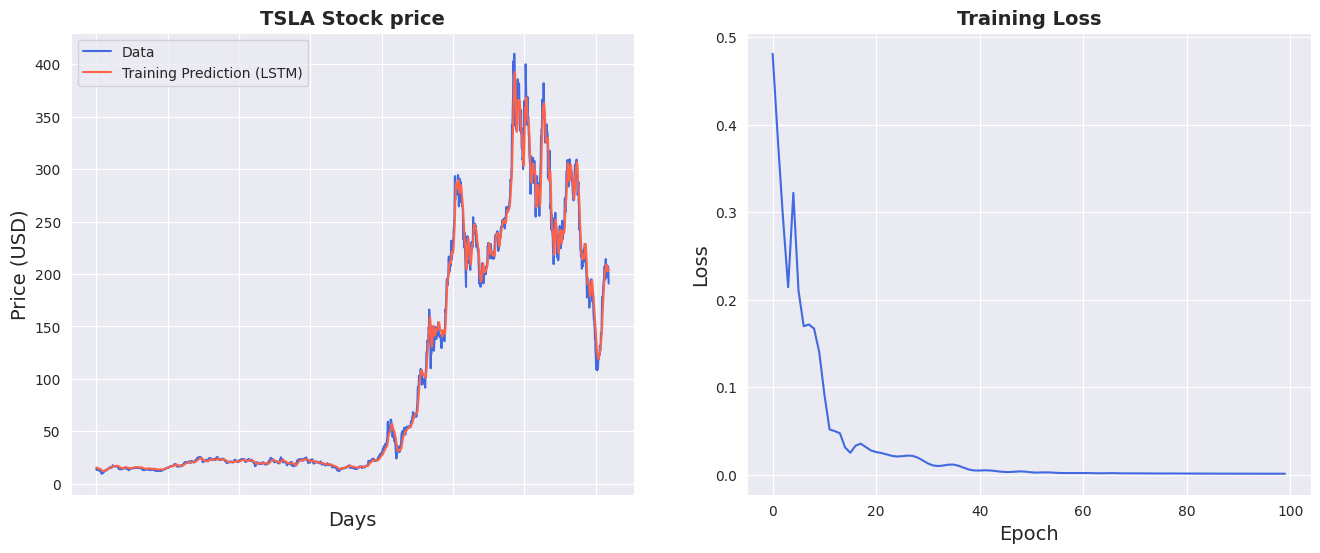

In [ ]:
plot_training_results(predict_lstm, original, lstm_train_losses, 'LSTM')

In [ ]:
def evaluation_lstm(model, x_test, y_test, y_train, y_train_pred):
  results = []
  y_test_pred = model(x_test)

  # Invert values
  y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
  y_train_orig = scaler.inverse_transform(y_train.detach().numpy())
  y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
  y_test_orig = scaler.inverse_transform(y_test.detach().numpy())

  # Calculate Root Mean Squared Error
  trainScore = math.sqrt(mean_squared_error(y_train_orig[:, 0], y_train_pred[:, 0]))
  print('Train Score: %.2f RMSE' % (trainScore))
  testScore = math.sqrt(mean_squared_error(y_test_orig[:, 0], y_test_pred[:, 0]))
  print('Test Score: %.2f RMSE' % (testScore))
  results.append(trainScore)
  results.append(testScore)
  results.append(lstm_training_time)
  return y_test_pred, results

In [ ]:
lstm_test_pred, lstm_result = evaluation_lstm(lstm, x_test, y_test, y_train, lstm_train_pred)

Train Score: 8.13 RMSE
Test Score: 12.00 RMSE


In [ ]:
predictions_plot(lstm_train_pred, lstm_test_pred, 'LSTM')

# *GRU Model Construction*

In [ ]:
class GRU(nn.Module):
  def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
    super(GRU, self).__init__()
    self.hidden_dim = hidden_dim
    self.num_layers = num_layers
    self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first = True)
    self.fc = nn.Linear(hidden_dim, output_dim)

  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
    out, (hn) = self.gru(x, (h0.detach()))
    out = self.fc(out[:, -1, :])
    return out

In [ ]:
gru = GRU(input_dim = input_dim, hidden_dim = hidden_dim, num_layers = num_layers, output_dim = output_dim)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(gru.parameters(), lr = 0.01)

In [ ]:
print(gru)

GRU(
  (gru): GRU(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)


# Train GRU

In [ ]:
def train_model_gru(model, x_train, y_train, num_epochs):
  train_losses = np.zeros(num_epochs)
  start_time = time.time()

  for epoch in range(num_epochs):
    y_train_pred = model(x_train)
    loss = criterion(y_train_pred, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print("Epoch ", epoch + 1, "MSE: ", loss.item())
    train_losses[epoch] = loss.item()

  training_time = time.time() - start_time
  print("Training time: {}".format(training_time))

  return y_train_pred, train_losses, training_time

In [ ]:
gru_train_pred, gru_training_losses, gru_training_time = train_model_gru(gru, x_train, y_train, num_epochs = 100)

Epoch  1 MSE:  0.4850424826145172
Epoch  2 MSE:  0.2378188669681549
Epoch  3 MSE:  0.16813090443611145
Epoch  4 MSE:  0.19020694494247437
Epoch  5 MSE:  0.11798270791769028
Epoch  6 MSE:  0.05511320382356644
Epoch  7 MSE:  0.03528141602873802
Epoch  8 MSE:  0.02574668824672699
Epoch  9 MSE:  0.017369000241160393
Epoch  10 MSE:  0.043182287365198135
Epoch  11 MSE:  0.036354850977659225
Epoch  12 MSE:  0.009618218056857586
Epoch  13 MSE:  0.003594373119994998
Epoch  14 MSE:  0.010559510439634323
Epoch  15 MSE:  0.014790646731853485
Epoch  16 MSE:  0.013436244800686836
Epoch  17 MSE:  0.011261571198701859
Epoch  18 MSE:  0.012309785932302475
Epoch  19 MSE:  0.014576960355043411
Epoch  20 MSE:  0.012948468327522278
Epoch  21 MSE:  0.0075060538947582245
Epoch  22 MSE:  0.003238326869904995
Epoch  23 MSE:  0.0027663835790008307
Epoch  24 MSE:  0.004123306833207607
Epoch  25 MSE:  0.0045112366788089275
Epoch  26 MSE:  0.0037884337361902
Epoch  27 MSE:  0.003925917204469442
Epoch  28 MSE:  0.0

In [ ]:
predict_gru = pd.DataFrame(scaler.inverse_transform(gru_train_pred.detach().numpy()))

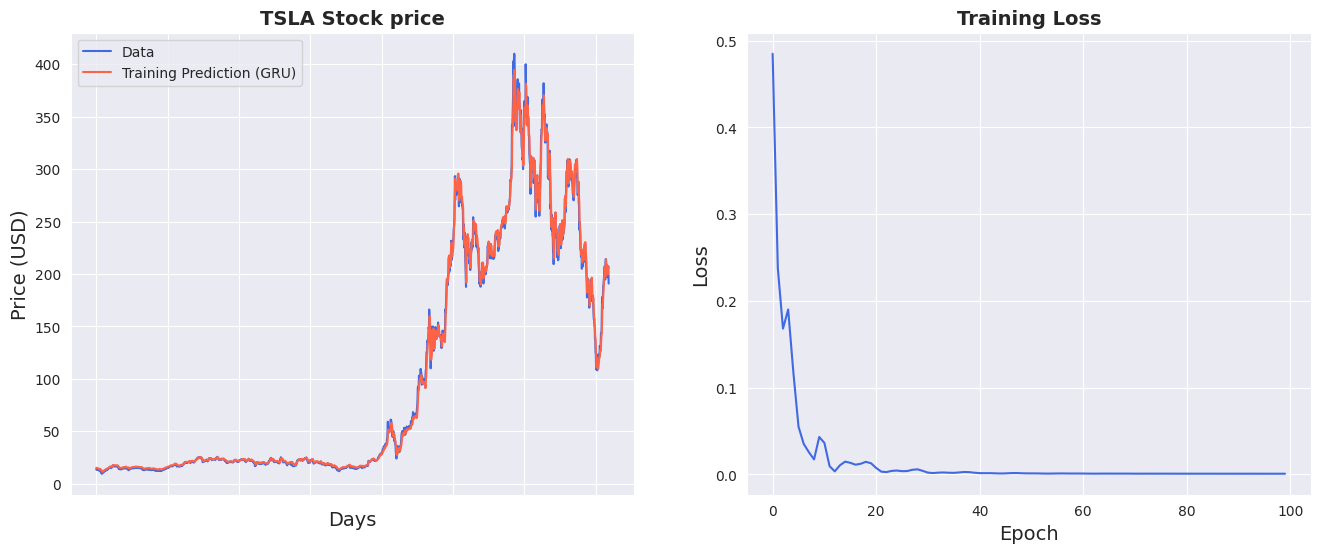

In [ ]:
plot_training_results(predict_gru, original, gru_training_losses, 'GRU')

In [ ]:
def evaluation_gru(model, x_test, y_test, y_train, y_train_pred):
  results = []
  y_test_pred = model(x_test)

  # Invert values
  y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
  y_train_orig = scaler.inverse_transform(y_train.detach().numpy())
  y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
  y_test_orig = scaler.inverse_transform(y_test.detach().numpy())

  # Calculate Root Mean Squared Error
  trainScore = math.sqrt(mean_squared_error(y_train_orig[:, 0], y_train_pred[:, 0]))
  print('Train Score: %.2f RMSE' % (trainScore))
  testScore = math.sqrt(mean_squared_error(y_test_orig[:, 0], y_test_pred[:, 0]))
  print('Test Score: %.2f RMSE' % (testScore))
  results.append(trainScore)
  results.append(testScore)
  results.append(gru_training_time)
  return y_test_pred, results

In [ ]:
gru_test_pred, gru_results = evaluation_gru(gru, x_test, y_test, y_train, gru_train_pred)

Train Score: 6.25 RMSE
Test Score: 8.89 RMSE


In [ ]:
predictions_plot(gru_train_pred, gru_test_pred, 'GRU')

In [ ]:
rnn_result_df=pd.DataFrame(rnn_result, columns=['RNN'])
lstm_result_df = pd.DataFrame(lstm_result, columns=['LSTM'])
gru_result_df = pd.DataFrame(gru_results, columns=['GRU'])
result = pd.concat([rnn_result_df,lstm_result_df, gru_result_df], axis=1, join='inner')
result.index = ['Train RMSE', 'Test RMSE', 'Train Time']
result

,RNN,LSTM,GRU
Train RMSE,6.405797,8.129480,6.252840
Test RMSE,9.078378,12.000156,8.893776
Train Time,1.898019,7.951025,5.731978


In [11]:
plt.hist(data['TSLA_5d_return'], bins=100)
plt.title("TSLA 5-Day Return Distribution")
plt.grid()
plt.show()

KeyError: 'TSLA_5d_return'

# *GRU-Based Return Prediction Model*

In [21]:
class GRUClassifier(nn.Module):
    def __init__(self, input_size, hidden_size=128, num_layers=2, dropout=0.3):
        super(GRUClassifier, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, bidirectional=False)
        self.dropout = nn.Dropout(dropout)
        self.norm = nn.LayerNorm(hidden_size)
        self.fc = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        h0 = torch.zeros(self.gru.num_layers, x.size(0), self.gru.hidden_size).to(x.device)
        out, _ = self.gru(x, h0)
        out = self.dropout(out[:, -1, :])
        out = self.norm(out)
        return self.sigmoid(self.fc(out))

In [138]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import joblib

def train_model(model, x_train, y_train, epochs=30, lr=0.00009, model_path=None, verbose=True):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(x_train.to(device)).squeeze()
        targets = y_train.to(device).squeeze()
        loss = criterion(outputs, targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        if verbose and (epoch + 1) % 5 == 0:
            preds_binary = (outputs.detach().cpu().numpy() >= 0.5).astype(int)
            true_binary = y_train.cpu().numpy().astype(int).flatten()
            acc = accuracy_score(true_binary, preds_binary)
            print(f"Epoch [{epoch+1}/{epochs}]  Loss: {loss.item():.6f}  Acc: {acc:.4f}")

    # Save model
    if model_path:
        torch.save(model.state_dict(), model_path)
        print(f"Model saved to {model_path}")

    return model

In [139]:
def evaluate_model(model, x_test, y_test, show_plot=True):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()

    with torch.no_grad():
        outputs = model(x_test.to(device)).squeeze()
        predicted_probs = outputs.cpu().numpy()
        predicted_labels = (predicted_probs >= 0.5).astype(int)
        true_labels = y_test.cpu().numpy().astype(int).flatten()

    # Metrics
    acc = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)
    cm = confusion_matrix(true_labels, predicted_labels)

    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    print("Confusion Matrix:\n", cm)

    if show_plot:
      plt.figure(figsize=(14, 6))

      # Plot predicted probabilities as a line
      plt.plot(predicted_probs, label='Predicted Probability', color='blue', linewidth=2)

      # Overlay actual direction (0/1) as vertical spans
      for i, val in enumerate(actual):
          if val == 1:
              plt.axvspan(i - 0.5, i + 0.5, color='orange', alpha=0.3)

      plt.title("TSLA Direction Prediction")
      plt.xlabel("Time Step")
      plt.ylabel("Probability / Direction")
      plt.ylim([-0.1, 1.1])
      plt.legend(loc="upper left")
      plt.grid(True)
      plt.tight_layout()
      plt.show()

    return predicted_probs, true_labels, acc, f1

In [ ]:
# Inference + Signal Classification (Buy Hold Sell)
def classify_signals(predicted_returns, buy_threshold=0.002, sell_threshold=-0.002):
    # Thresholds can be tuned
    signals = []

    for r in predicted_returns:
        if r > buy_threshold:
            signals.append('Buy')
        elif r < sell_threshold:
            signals.append('Sell')
        else:
            signals.append('Hold')

    return np.array(signals)

In [ ]:
# Model Load
def load_model(model_class, model_path, input_size, hidden_size, num_layers=2):
    model = model_class(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    print(f"Model loaded from {model_path}")
    return model

In [81]:
# Initialize model
model = GRUClassifier(input_size=x_train.shape[2])

In [40]:
print(x_train.dtype)
print(x_train.shape)
print(x_train[0])

torch.float32
torch.Size([1841, 20, 15])
tensor([[-0.5135, -0.8555, -0.8499,  0.0322, -0.2327,  0.7069, -1.0509, -0.1607,
         -0.0456,  0.0000, -0.6313, -0.7045, -0.7258, -0.3660, -0.7973],
        [-0.5130, -0.8454, -0.8279,  0.0159, -0.2612,  0.4391, -0.8362, -0.1608,
         -0.1012,  0.0000, -0.6443, -0.5056, -0.6916, -0.3654,  0.1991],
        [-0.5112, -0.8440, -0.8283, -0.1894, -0.2427,  0.4125, -1.0899, -0.1688,
         -0.3612,  0.0000, -0.1878, -0.7447, -0.6905, -0.3636,  0.1787],
        [-0.5156, -0.8548, -0.8449, -0.3360, -0.2966,  0.6538, -1.1919, -0.1778,
          0.7585,  0.0000, -0.7960, -0.7371, -0.7020, -0.3623,  0.7737],
        [-0.5185, -0.8571, -0.8395, -0.0851, -0.2876,  0.6140, -1.3704, -0.1915,
         -0.0823,  0.0000, -1.0490, -0.8794, -0.8338, -0.3596, -1.9687],
        [-0.5179, -0.8572, -0.8380, -0.1568, -0.2966,  0.6369, -1.2315, -0.1982,
          0.4623,  0.0000, -0.9851, -0.6617, -0.8046, -0.3627, -1.4032],
        [-0.5219, -0.8740, -0.8555,

In [26]:
# Convert numpy arrays to torch tensors
x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).float()
x_test = torch.from_numpy(x_test).float()
y_test = torch.from_numpy(y_test).float()

In [32]:
print("NaN in y_train:", torch.isnan(y_train).sum().item())
print("Inf in y_train:", torch.isinf(y_train).sum().item())
print("Min/Max y_train:", y_train.min().item(), y_train.max().item())

NaN in y_train: 0
Inf in y_train: 0
Min/Max y_train: -0.43045899271965027 0.5647557973861694


In [33]:
print("NaN in x_train:", torch.isnan(x_train).sum().item())
print("Inf in x_train:", torch.isinf(x_train).sum().item())
print("Max x_train:", x_train.max().item())
print("Min x_train:", x_train.min().item())

NaN in x_train: 0
Inf in x_train: 0
Max x_train: 10.667686462402344
Min x_train: -7.152061939239502


In [82]:
# Train
model = train_model(model, x_train, y_train, epochs=200, model_path='tsla_gru_return_model.pt')

Epoch [5/200]  Loss: 0.688049  Acc: 0.5557
Epoch [10/200]  Loss: 0.684401  Acc: 0.5557
Epoch [15/200]  Loss: 0.683343  Acc: 0.5557
Epoch [20/200]  Loss: 0.681005  Acc: 0.5557
Epoch [25/200]  Loss: 0.680268  Acc: 0.5557
Epoch [30/200]  Loss: 0.678869  Acc: 0.5557
Epoch [35/200]  Loss: 0.677300  Acc: 0.5557
Epoch [40/200]  Loss: 0.677435  Acc: 0.5557
Epoch [45/200]  Loss: 0.676646  Acc: 0.5557
Epoch [50/200]  Loss: 0.675181  Acc: 0.5557
Epoch [55/200]  Loss: 0.674125  Acc: 0.5557
Epoch [60/200]  Loss: 0.672253  Acc: 0.5557
Epoch [65/200]  Loss: 0.672495  Acc: 0.5557
Epoch [70/200]  Loss: 0.672037  Acc: 0.5557
Epoch [75/200]  Loss: 0.670829  Acc: 0.5557
Epoch [80/200]  Loss: 0.669127  Acc: 0.5557
Epoch [85/200]  Loss: 0.669290  Acc: 0.5557
Epoch [90/200]  Loss: 0.668521  Acc: 0.5557
Epoch [95/200]  Loss: 0.667527  Acc: 0.5557
Epoch [100/200]  Loss: 0.666517  Acc: 0.5557
Epoch [105/200]  Loss: 0.665663  Acc: 0.5557
Epoch [110/200]  Loss: 0.665978  Acc: 0.5557
Epoch [115/200]  Loss: 0.66367

Accuracy:    0.4587
Precision:   0.4587
Recall:      1.0000
F1 Score:    0.6289
Confusion Matrix:
 [[  0 249]
 [  0 211]]


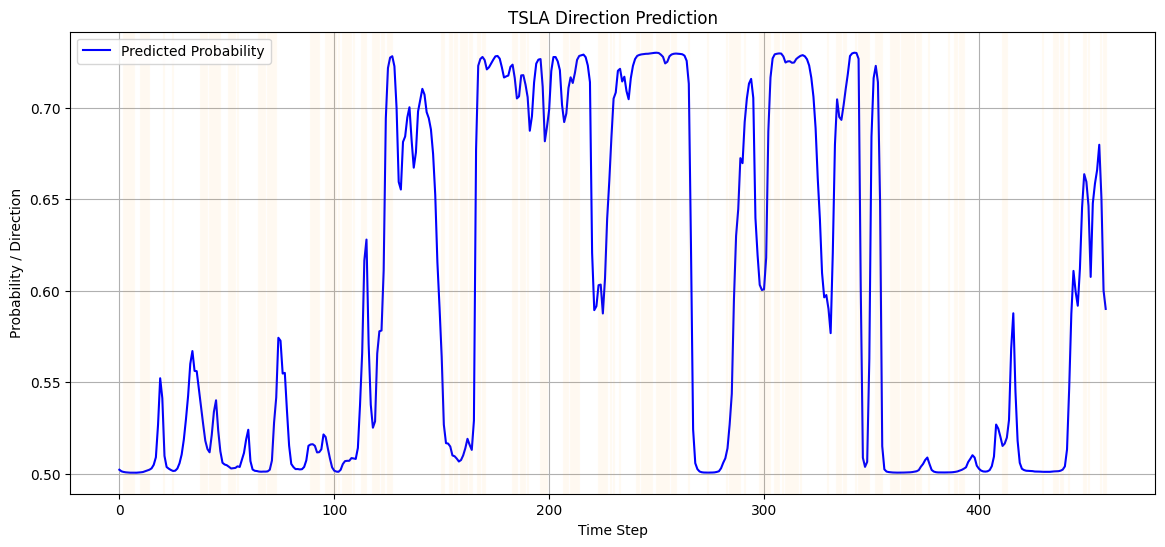

In [83]:
# Evaluate
predicted, actual, acc, f1 = evaluate_model(model, x_test, y_test)

Negative R-squared means model is worse than simply predicting the mean return for all test samples

In [ ]:
# Generate trading signals
signals = classify_signals(predicted.flatten())
print("Sample signals:", signals[:10])

Sample signals: ['Sell' 'Buy' 'Buy' 'Buy' 'Buy' 'Buy' 'Buy' 'Buy' 'Buy' 'Sell']


# *Customized Model Construction*

In [140]:
class GRUWithAttentionClassifier(nn.Module):
    def __init__(self, input_size, hidden_size=128, num_layers=2, dropout=0.3, bidirectional=False):
        super(GRUWithAttentionClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_directions = 2 if bidirectional else 1

        self.gru = nn.GRU(input_size, hidden_size, num_layers,
                          batch_first=True, dropout=dropout if num_layers > 1 else 0,
                          bidirectional=bidirectional)

        self.attn = nn.Linear(hidden_size * self.num_directions, 1)
        self.dropout = nn.Dropout(dropout)
        self.norm = nn.LayerNorm(hidden_size * self.num_directions)
        self.fc = nn.Linear(hidden_size * self.num_directions, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        h0 = torch.zeros(self.num_layers * self.num_directions, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.gru(x, h0)  # (batch, seq_len, hidden_size * directions)

        # Attention
        attn_scores = self.attn(out).squeeze(-1)  # (batch, seq_len)
        attn_weights = torch.softmax(attn_scores, dim=1)  # (batch, seq_len)
        context = torch.sum(out * attn_weights.unsqueeze(-1), dim=1)  # (batch, hidden_size)

        out = self.dropout(context)
        out = self.norm(out)
        return self.sigmoid(self.fc(out))

In [103]:
class GRUWithAttentionClassifier(nn.Module):
    def __init__(self, input_size, hidden_size=128, num_layers=2, dropout=0.3, bidirectional=False):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_directions = 2 if bidirectional else 1

        self.gru = nn.GRU(input_size, hidden_size, num_layers,
                          batch_first=True, dropout=dropout if num_layers > 1 else 0,
                          bidirectional=bidirectional)

        self.attn = nn.Linear(hidden_size * self.num_directions, 1)
        self.dropout = nn.Dropout(dropout)
        self.norm = nn.LayerNorm(hidden_size * self.num_directions)
        self.fc = nn.Linear(hidden_size * self.num_directions, 1)
        # self.sigmoid = nn.Sigmoid() ← REMOVE THIS

    def forward(self, x):
        h0 = torch.zeros(self.num_layers * self.num_directions, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.gru(x, h0)

        attn_scores = self.attn(out).squeeze(-1)
        attn_weights = torch.softmax(attn_scores, dim=1)
        context = torch.sum(out * attn_weights.unsqueeze(-1), dim=1)

        out = self.dropout(context)
        out = self.norm(out)
        return self.fc(out)

In [104]:
def train_model(model, x_train, y_train, epochs=30, lr=0.0001, model_path=None, verbose=True):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    # Compute pos_weight for BCEWithLogitsLoss
    num_pos = y_train.sum().item()
    num_neg = y_train.shape[0] - num_pos
    pos_weight = torch.tensor([num_neg / num_pos], dtype=torch.float32).to(device)

    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(x_train.to(device)).view(-1)
        loss = criterion(outputs, y_train.to(device).view(-1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        if verbose and (epoch + 1) % 5 == 0:
            probs = torch.sigmoid(outputs).detach().cpu().numpy()
            preds = (probs >= 0.5).astype(int)
            labels = y_train.cpu().numpy().astype(int).flatten()
            acc = accuracy_score(labels, preds)
            print(f"Epoch [{epoch+1}/{epochs}]  Loss: {loss.item():.6f}  Acc: {acc:.4f}")

    # Save model
    if model_path:
        torch.save(model.state_dict(), model_path)
        print(f"✅ Model saved to {model_path}")

    return model


# ----------------------------
# Evaluate Model
# ----------------------------
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

def evaluate_model(model, x_test, y_test, show_plot=True):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()

    with torch.no_grad():
        logits = model(x_test.to(device)).squeeze()
        probs = torch.sigmoid(logits)
        predicted_probs = probs.cpu().numpy()
        predicted_labels = (predicted_probs >= 0.5).astype(int)
        true_labels = y_test.cpu().numpy().astype(int).flatten()

    acc = accuracy_score(true_labels, predicted_labels)
    prec = precision_score(true_labels, predicted_labels)
    rec = recall_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)
    cm = confusion_matrix(true_labels, predicted_labels)

    print(f"Accuracy:    {acc:.4f}")
    print(f"Precision:   {prec:.4f}")
    print(f"Recall:      {rec:.4f}")
    print(f"F1 Score:    {f1:.4f}")
    print("Confusion Matrix:\n", cm)

    if show_plot:
        plt.figure(figsize=(14, 6))
        plt.plot(predicted_probs, label='Predicted Probability', color='blue')
        for i, label in enumerate(true_labels):
            if label == 1:
                plt.axvline(i, color='orange', alpha=0.05)
        plt.title('TSLA Direction Prediction')
        plt.xlabel('Time Step')
        plt.ylabel('Probability / Direction')
        plt.legend(loc='upper left')
        plt.grid(True)
        plt.show()

    return predicted_probs, true_labels, acc, f1

In [141]:
# GRU with Attention
model = GRUWithAttentionClassifier(
    input_size=x_train.shape[2],
    hidden_size=128,
    num_layers=2,
    dropout=0.1,
    bidirectional = False
)

In [142]:
model = train_model(model, x_train, y_train, epochs=200, model_path="tsla_attention.pt")

Epoch [5/200]  Loss: 0.690668  Acc: 0.5454
Epoch [10/200]  Loss: 0.687703  Acc: 0.5416
Epoch [15/200]  Loss: 0.683647  Acc: 0.5644
Epoch [20/200]  Loss: 0.680361  Acc: 0.5741
Epoch [25/200]  Loss: 0.681544  Acc: 0.5709
Epoch [30/200]  Loss: 0.678260  Acc: 0.5888
Epoch [35/200]  Loss: 0.673905  Acc: 0.5872
Epoch [40/200]  Loss: 0.670577  Acc: 0.5932
Epoch [45/200]  Loss: 0.672594  Acc: 0.5894
Epoch [50/200]  Loss: 0.668170  Acc: 0.5883
Epoch [55/200]  Loss: 0.667121  Acc: 0.5975
Epoch [60/200]  Loss: 0.666037  Acc: 0.5986
Epoch [65/200]  Loss: 0.665219  Acc: 0.6035
Epoch [70/200]  Loss: 0.662883  Acc: 0.5986
Epoch [75/200]  Loss: 0.664688  Acc: 0.6089
Epoch [80/200]  Loss: 0.663958  Acc: 0.5975
Epoch [85/200]  Loss: 0.660912  Acc: 0.5888
Epoch [90/200]  Loss: 0.661098  Acc: 0.5986
Epoch [95/200]  Loss: 0.659493  Acc: 0.6008
Epoch [100/200]  Loss: 0.659525  Acc: 0.5953
Epoch [105/200]  Loss: 0.660211  Acc: 0.6040
Epoch [110/200]  Loss: 0.659302  Acc: 0.5997
Epoch [115/200]  Loss: 0.65884

Accuracy:  0.5130
Precision: 0.4831
Recall:    0.8815
F1 Score:  0.6242
Confusion Matrix:
 [[ 50 199]
 [ 25 186]]


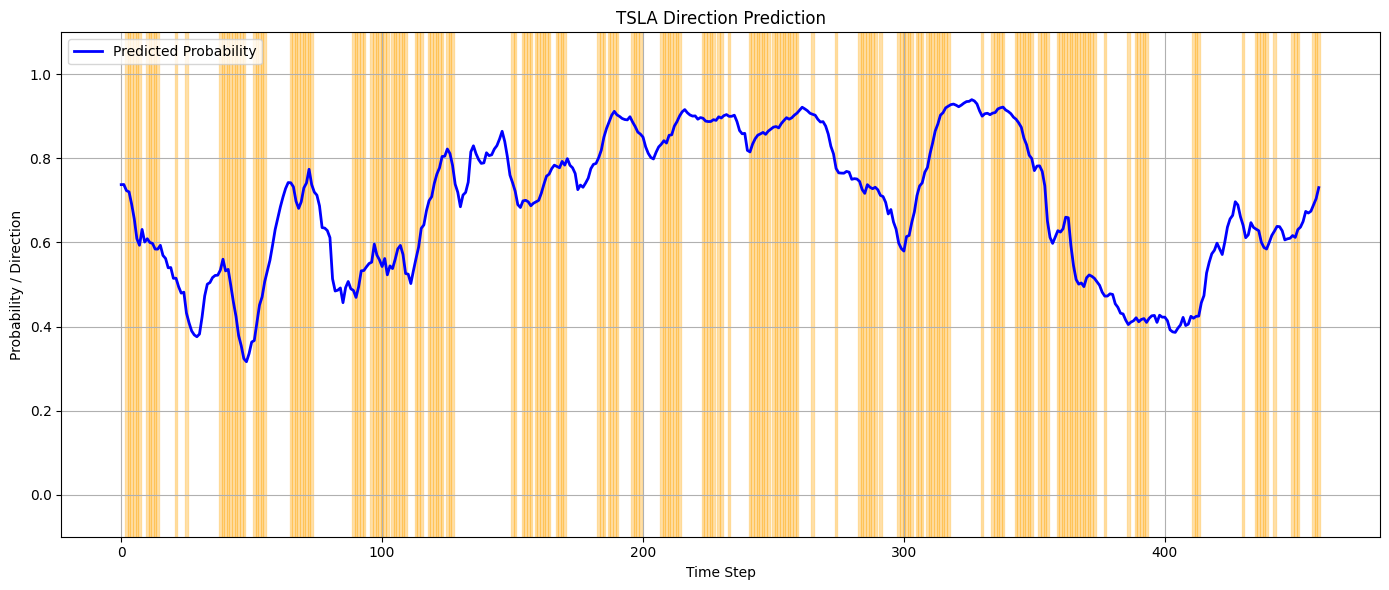

In [143]:
predicted, actual, acc, f1 = evaluate_model(model, x_test, y_test)

# *LSTM-Based Return Prediction Model*

In [40]:
class LSTMReturnModel(nn.Module):
    def __init__(self, input_size, hidden_size=128, num_layers=2, dropout=0.3):
        super(LSTMReturnModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # Use the last output
        return out

In [41]:
model = LSTMReturnModel(input_size = x_train.shape[2], hidden_size = 128)
model = train_model(model, x_train, y_train, epochs = 200, model_path = 'tsla_lstm_return_model.pt')

Epoch [5/200], Loss: 0.007635
Epoch [10/200], Loss: 0.007429
Epoch [15/200], Loss: 0.007328
Epoch [20/200], Loss: 0.007206
Epoch [25/200], Loss: 0.007124
Epoch [30/200], Loss: 0.007126
Epoch [35/200], Loss: 0.007095
Epoch [40/200], Loss: 0.007042
Epoch [45/200], Loss: 0.007018
Epoch [50/200], Loss: 0.007011
Epoch [55/200], Loss: 0.006975
Epoch [60/200], Loss: 0.006920
Epoch [65/200], Loss: 0.006931
Epoch [70/200], Loss: 0.006886
Epoch [75/200], Loss: 0.006830
Epoch [80/200], Loss: 0.006751
Epoch [85/200], Loss: 0.006711
Epoch [90/200], Loss: 0.006674
Epoch [95/200], Loss: 0.006709
Epoch [100/200], Loss: 0.006572
Epoch [105/200], Loss: 0.006547
Epoch [110/200], Loss: 0.006508
Epoch [115/200], Loss: 0.006441
Epoch [120/200], Loss: 0.006433
Epoch [125/200], Loss: 0.006380
Epoch [130/200], Loss: 0.006297
Epoch [135/200], Loss: 0.006306
Epoch [140/200], Loss: 0.006242
Epoch [145/200], Loss: 0.006081
Epoch [150/200], Loss: 0.006123
Epoch [155/200], Loss: 0.006030
Epoch [160/200], Loss: 0.005

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, max_seq_len, hidden_dim):
        super(PositionalEncoding, self).__init__()
        self.pos_embed = nn.Parameter(torch.randn(1, max_seq_len, hidden_dim))

    def forward(self, x):
        return x + self.pos_embed[:, :x.size(1), :]

In [ ]:
import torch.nn.functional as F

class SelfAttention(nn.Module):
    def __init__(self, hidden_dim):
        super(SelfAttention, self).__init__()
        self.query = nn.Linear(hidden_dim, hidden_dim)
        self.key = nn.Linear(hidden_dim, hidden_dim)
        self.value = nn.Linear(hidden_dim, hidden_dim)
        self.scale = torch.sqrt(torch.tensor(hidden_dim, dtype=torch.float32))

    def forward(self, x):
        # x shape: [batch, seq_len, hidden_dim]
        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)

        scores = torch.bmm(Q, K.transpose(1, 2)) / self.scale.to(x.device)  # [batch, seq_len, seq_len]
        attn_weights = F.softmax(scores, dim=-1)  # [batch, seq_len, seq_len]
        output = torch.bmm(attn_weights, V)       # [batch, seq_len, hidden_dim]
        return output, attn_weights

In [ ]:
class Customized_SelfAttention_Model(nn.Module):
    def __init__(self, input_dim, cnn_filters, hidden_dim, num_layers, output_dim, dropout_prob=0.3):
        super(Customized_SelfAttention_Model, self).__init__()

        # CNN for local pattern extraction
        self.conv1 = nn.Conv1d(in_channels=input_dim, out_channels=cnn_filters, kernel_size=3, padding=1)
        self.norm = nn.LayerNorm(cnn_filters)
        self.relu = nn.ReLU()

        # GRU to encode temporal dynamics
        self.gru = nn.GRU(input_size=cnn_filters, hidden_size=hidden_dim, num_layers=num_layers,
                          batch_first=True, bidirectional=False, dropout=dropout_prob)

        # Self-Attention Layer
        self.self_attn = SelfAttention(hidden_dim)

        # Output layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x):
        # x shape: [batch, seq_len, input_dim]
        x = self.conv1(x.permute(0, 2, 1))  # → [batch, cnn_filters, seq_len]
        x = self.relu(self.norm(x.permute(0, 2, 1)))  # → [batch, seq_len, cnn_filters]

        gru_out, _ = self.gru(x)  # → [batch, seq_len, hidden_dim]

        attn_out, _ = self.self_attn(gru_out)  # → [batch, seq_len, hidden_dim]

        # Pool over time (mean or last timestep)
        context = torch.mean(attn_out, dim=1)  # or: attn_out[:, -1, :]

        output = self.fc(self.dropout(context))
        return output


In [ ]:
cnn_filters = 16
cm = Customized_SelfAttention_Model(input_dim = input_dim, cnn_filters = cnn_filters, hidden_dim = 128, num_layers = num_layers, output_dim = output_dim,
                            dropout_prob = 0.3)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(cm.parameters(), lr = 0.001)
print(cm)

Customized_SelfAttention_Model(
  (conv1): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=(1,))
  (norm): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
  (relu): ReLU()
  (gru): GRU(16, 128, num_layers=2, batch_first=True, dropout=0.3)
  (self_attn): SelfAttention(
    (query): Linear(in_features=128, out_features=128, bias=True)
    (key): Linear(in_features=128, out_features=128, bias=True)
    (value): Linear(in_features=128, out_features=128, bias=True)
  )
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


# Train Customized model

In [ ]:
# Train the Customized model
def train_customized_model(model, x_train, y_train, num_epochs, scheduler = None, patience = 5):
  train_losses = np.zeros(num_epochs)
  best_loss = float('inf')
  epochs_no_improvement = 0
  start_time = time.time()

  for epoch in range(num_epochs):
    y_train_pred = model(x_train)
    loss = criterion(y_train_pred, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if scheduler:
      scheduler.step(loss)

    train_losses[epoch] = loss.item()

    if loss.item() < best_loss:
      best_loss = loss.item()
      epochs_no_improvement = 0
    else:
      epochs_no_improvement += 1

    print("Epoch ", epoch + 1, "MSE: ", loss.item())

    if epochs_no_improvement >= patience:
      print(f"Early stop triggered after {epoch + 1} epochs")
      break

  training_time = time.time() - start_time
  print("Training time: {}".format(training_time))

  return y_train_pred, train_losses, training_time

In [ ]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min', factor = 0.5, patience = 5)

In [ ]:
cm_train_pred, cm_training_losses, cm_training_time = train_customized_model(cm, x_train, y_train, num_epochs = 100, scheduler = scheduler, patience = 5)

Epoch  1 MSE:  0.011504645459353924
Epoch  2 MSE:  0.011700397357344627
Epoch  3 MSE:  0.011760709807276726
Epoch  4 MSE:  0.011925335973501205
Epoch  5 MSE:  0.012072463519871235
Epoch  6 MSE:  0.011654858477413654
Early stop triggered after 6 epochs
Training time: 2.3988354206085205


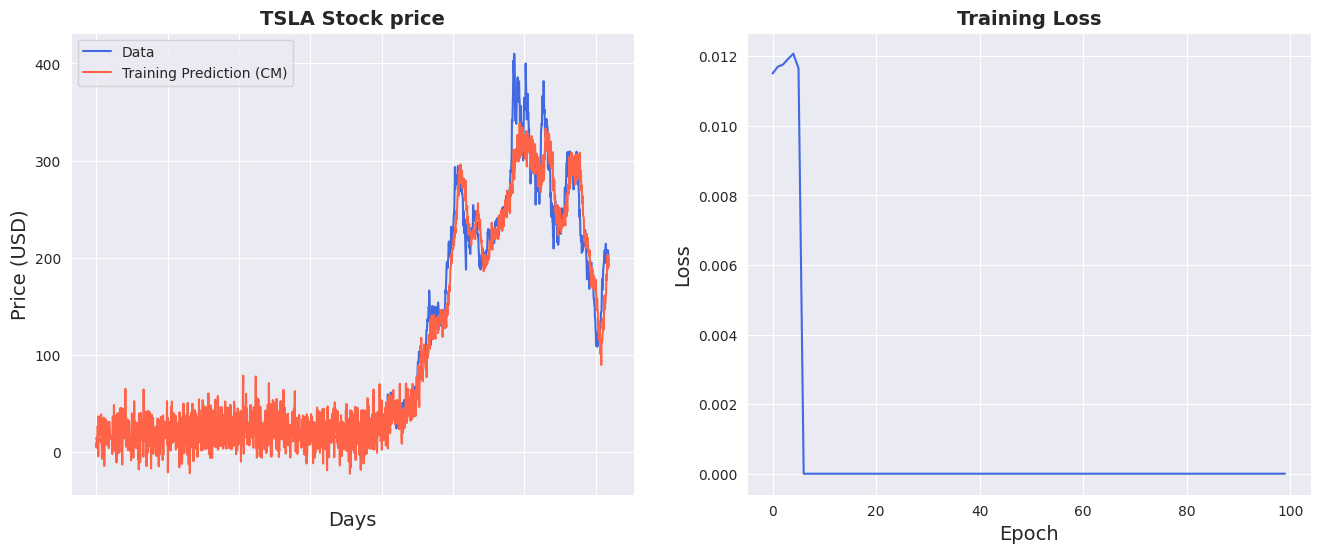

In [ ]:
predict_cm = pd.DataFrame(scaler.inverse_transform(cm_train_pred.detach().numpy()))
plot_training_results(predict_cm, original, cm_training_losses, 'CM')

In [ ]:
def evaluation_customized_model(model, x_test, y_test, y_train, y_train_pred):
  results = []
  y_test_pred = model(x_test)

  # Invert values
  y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
  y_train_orig = scaler.inverse_transform(y_train.detach().numpy())
  y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
  y_test_orig = scaler.inverse_transform(y_test.detach().numpy())

  # Calculate Root Mean Squared Error
  trainScore = math.sqrt(mean_squared_error(y_train_orig[:, 0], y_train_pred[:, 0]))
  print('Train Score: %.2f RMSE' % (trainScore))
  testScore = math.sqrt(mean_squared_error(y_test_orig[:, 0], y_test_pred[:, 0]))
  print('Test Score: %.2f RMSE' % (testScore))
  results.append(trainScore)
  results.append(testScore)
  results.append(gru_training_time)
  return y_test_pred, results

In [ ]:
cm_test_pred, cm_results = evaluation_customized_model(cm, x_test, y_test, y_train, cm_train_pred)

Train Score: 23.03 RMSE
Test Score: 27.95 RMSE


In [ ]:
predictions_plot(cm_train_pred, cm_test_pred, 'CM')

# ***Integrate LangChain***

In [ ]:
from langchain.chains.summarize import load_summarize_chain
chain = load_summarize_chain(llm, chain_type="map_reduce")
summary = chain.run(transcript_text)

# ***Prediction of the Future Prices***

In [ ]:
# Multi-step prediction using RNN model
def predict_price_rnn(model, recent_data, steps, hidden_dim, num_layers):
  predictions = []
  current_input = recent_data
  hidden = torch.zeros(num_layers, 1, hidden_dim)

  for step in range(steps):
    with torch.no_grad():
      input_tensor = torch.tensor(current_input, dtype = torch.float32).view(1, -1, 1)
      #print(f"Step {step} - Input Tensor Shape: {input_tensor.shape}") # Debugging step
      pred, hidden = model(input_tensor, hidden)
      #print(f"Step {step} - Output Tensor Shape: {pred.shape}") # Debugging step
      predictions.append(pred.item())
      current_input = np.append(current_input[1:], pred.item())
  return predictions

In [ ]:
# Define the parameters
hidden_dim = 32
num_layers = 2
future_steps = 200
recent_data = x_test[-1].numpy()
print(recent_data)

[[0.4138079 ]
 [0.45852822]
 [0.5429998 ]
 [0.57703227]
 [0.55842227]
 [0.54721886]
 [0.6077833 ]
 [0.5422967 ]
 [0.54060924]
 [0.51557714]
 [0.57309467]
 [0.6290184 ]
 [0.60243946]
 [0.632956  ]
 [0.6871454 ]
 [0.779633  ]
 [0.782305  ]
 [0.83480674]
 [0.9462793 ]]


In [ ]:
future_predictions = predict_price_rnn(rnn, recent_data, future_steps, hidden_dim, num_layers)

In [ ]:
# Inverse transform the values
future_predictions = np.array(future_predictions).reshape(-1, 1)
future_predictions = scaler.inverse_transform(future_predictions)
print(future_predictions)

[[403.61376585]
 [394.28645208]
 [383.8455647 ]
 [374.24465751]
 [364.33625815]
 [355.96325983]
 [349.25038618]
 [344.03063547]
 [339.41587496]
 [335.70442917]
 [332.65665432]
 [330.10004303]
 [327.85786007]
 [325.94546543]
 [324.30201043]
 [322.85941142]
 [321.58846152]
 [320.47317772]
 [319.49278334]
 [318.62472793]
 [317.85311747]
 [317.16711224]
 [316.55599966]
 [316.00960119]
 [315.52014784]
 [315.08135828]
 [314.68752339]
 [314.33352529]
 [314.01509166]
 [313.7285033 ]
 [313.47039067]
 [313.23777207]
 [313.02801543]
 [312.83878115]
 [312.66799667]
 [312.51379283]
 [312.37450394]
 [312.24865504]
 [312.13489832]
 [312.03205126]
 [311.93904577]
 [311.85491552]
 [311.77881492]
 [311.70993657]
 [311.64760656]
 [311.59117641]
 [311.54010572]
 [311.49385411]
 [311.45198288]
 [311.41405338]
 [311.37970321]
 [311.34859542]
 [311.3204185 ]
 [311.29488633]
 [311.27175735]
 [311.25080266]
 [311.23181884]
 [311.2146215 ]
 [311.19903264]
 [311.18491239]
 [311.17210816]
 [311.16051824]
 [311.15

Predictions for future price appear to be bad, and not logical in some ways. We need to figure out the solutions, and further the project into more in-depth hygeines.